In [0]:
import json

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 73 Jun 12 07:20 kaggle.json
{"username":"sumitbhattacharya","key":"42781fe0c37baee206338a2f994bb201"}

In [0]:
!pip install -q kaggle

In [0]:
!kaggle datasets list -s breast-histopathology

ref                                             title                         size  lastUpdated          downloadCount  
----------------------------------------------  ----------------------------  ----  -------------------  -------------  
paultimothymooney/breast-histopathology-images  Breast Histopathology Images   1GB  2017-12-19 05:46:40           6052  


In [0]:
!kaggle datasets download --force paultimothymooney/breast-histopathology-images

 99% 1.47G/1.49G [00:35<00:00, 41.6MB/s]
100% 1.49G/1.49G [00:35<00:00, 45.1MB/s]


In [0]:
!mkdir dataset

In [0]:
!unzip breast-histopathology-images.zip

Archive:  breast-histopathology-images.zip
  inflating: IDC_regular_ps50_idx5.zip  


In [0]:
cd /content/dataset

/content/dataset


In [0]:
!unzip /content/IDC_regular_ps50_idx5.zip

In [0]:
cd /content

/content


In [0]:
!mkdir clean_dir

In [0]:
import os

In [0]:
ORIG_INPUT_DATASET = "/content/dataset"
BASE_PATH = "/content/clean_dir"
 
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
 
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

In [0]:
from imutils import paths
import random
import shutil

In [0]:
list(paths.list_images(ORIG_INPUT_DATASET))[0].split(os.path.sep)[-1]

'12897_idx5_x1651_y701_class1.png'

In [0]:
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(40)
random.shuffle(imagePaths)

# Train-Val-Test Split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

j = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:j]
trainPaths = trainPaths[j:]

datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH),
	("testing", testPaths, TEST_PATH)
]

# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:

	# if the output base output directory does not exist, creating it
	if not os.path.exists(baseOutput):
		os.makedirs(baseOutput)

	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image and extract the
		# class label ("0" for "negative" and "1" for "positive")
		filename = inputPath.split(os.path.sep)[-1]
		label = filename[-5:-4]

		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			os.makedirs(labelPath)

		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [0]:
K.image_data_format()

'channels_last'

In [0]:
class NeuralNet:
	@staticmethod
	def build(width, height, depth, classes=2):
		# initialize the model along with the input shape to be channels_last and the channels dimension 
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1


		# CONV => RELU => BATCHNORM => POOLING => DROPOUT
		model.add(SeparableConv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU => BATCHNORM) * 2 => POOLING => DROPOUT
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU => BATCHNORM) * 3 => POOLING => DROPOUT
		model.add(SeparableConv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# FLATTEN => DENSE => RELU => BATCHNORM => DROPOUT
		model.add(Flatten())
		model.add(Dense(256))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# DENSE => SOFTMAX
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		
		return model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import numpy as np

In [0]:
NUM_EPOCHS = 20
INIT_LR = 1e-2
Batch = 64

In [0]:
trainPaths = list(paths.list_images(TRAIN_PATH))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

# Calculating class weights due to imbalanced dataset
trainLabels = [int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels = np_utils.to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
classTotals

array([143214.,  56604.], dtype=float32)

In [0]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")


In [0]:
valAug = ImageDataGenerator(rescale=1 / 255.0)
testAug = ImageDataGenerator(rescale =1 /255.0)

In [0]:
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=Batch)

Found 199818 images belonging to 2 classes.


In [0]:
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=Batch)

Found 22201 images belonging to 2 classes.


In [0]:
testGen = testAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=Batch)


Found 55505 images belonging to 2 classes.


In [0]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
model = NeuralNet.build(width=48, height=48, depth=3)
opt = Adagrad(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
hist = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // Batch,
	validation_data=valGen,
	validation_steps=totalVal // Batch,
	class_weight=classWeight,
	epochs=NUM_EPOCHS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3122/3122 [==============================] - 367s 117ms/step - loss: 0.3690 - acc: 0.8436 - val_loss: 0.5501 - val_acc: 0.7688
Epoch 2/20
3122/3122 [==============================] - 364s 117ms/step - loss: 0.3383 - acc: 0.8557 - val_loss: 0.4631 - val_acc: 0.8051
Epoch 3/20
3122/3122 [==============================] - 363s 116ms/step - loss: 0.3334 - acc: 0.8583 - val_loss: 0.4153 - val_acc: 0.8286
Epoch 4/20
3122/3122 [==============================] - 367s 117ms/step - loss: 0.3315 - acc: 0.8582 - val_loss: 0.4352 - val_acc: 0.8205
Epoch 5/20
3122/3122 [==============================] - 368s 118ms/step - loss: 0.3301 - acc: 0.8589 - val_loss: 0.4420 - val_acc: 0.8184
Epoch 6/20
3122/3122 [==============================] - 366s 117ms/step - loss: 0.3284 - acc: 0.8595 - val_loss: 0.4200 - val_acc: 0.8264
Epoch 7/20
3122/3122 [==============================] - 366s 117ms/step - loss: 0.3291 - acc: 0.8592 - val_loss: 0.4207 - va

In the midst of the 19th Epoch, the training terminated due to RAM issue on COLAB.

In [0]:
predId = model.predict_generator(testGen,
	steps=(totalTest // Batch) + 1)
 

In [0]:
predId = np.argmax(predId, axis=1)
print(classification_report(testGen.classes, predId,
	target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     39677
           1       0.66      0.85      0.74     15828

    accuracy                           0.83     55505
   macro avg       0.79      0.83      0.81     55505
weighted avg       0.85      0.83      0.83     55505



In [0]:
cm = confusion_matrix(testGen.classes, predId)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
 
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[32644  7033]
 [ 2436 13392]]
acc: 0.8294
sensitivity: 0.8227
specificity: 0.8461


In [0]:
import matplotlib.pyplot as plt

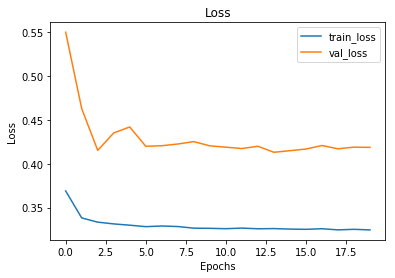

In [0]:
plt.plot(np.arange(0, NUM_EPOCHS), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), hist.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

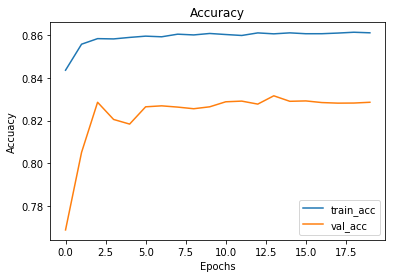

In [0]:
plt.plot(np.arange(0, NUM_EPOCHS), hist.history["acc"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), hist.history["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuacy")
plt.legend(loc="best")

##### FINAL ACCURACY ON TEST DATASET:  ~83%